<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/demo_LowRankSparse_BackgroundSubtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background Subtraction by Low-rank and Sparse Modeling

In [1]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_reserved())
    torch.cuda.empty_cache()

Tesla P100-PCIE-16GB
0
0


In [2]:
#@title ## Download and extract data zipfile
import zipfile
import os

root_dir = "/tmp/hall"
if not os.path.isdir(root_dir):
    !wget --no-check-certificate --show-progress -q\
        "https://www.dropbox.com/s/hof9g5af1964j8r/hall.zip?dl=1" \
        -O "/tmp/hall.zip"
    
    zip_filename = "/tmp/hall.zip"
    zip_ref = zipfile.ZipFile(zip_filename, 'r')
    zip_ref.extractall(root_dir)
    zip_ref.close()

imageseq_files = sorted(os.listdir(root_dir))

from PIL import Image
import numpy as np

im = np.array(Image.open(root_dir + '/' + imageseq_files[0]))
imageseq = []
for filename in imageseq_files:
    fullname = root_dir + '/' + filename
    if os.path.isfile(fullname):
        imageseq.append(np.array(Image.open(fullname).convert('L')))

imageseq = np.array(imageseq)
print(imageseq.shape)


# Matrix shape
frames_begin, frames_end = 0, 100
nframes = frames_end - frames_begin
DDseq = imageseq[frames_begin:frames_end,:,:].copy().astype(float) / 255.
DDseq_t = imageseq[-nframes:,:,:].copy().astype(float) / 255.

DD = DDseq.reshape(nframes,imageseq.shape[1]*imageseq.shape[2]).T
DD_t = DDseq_t.reshape(nframes,imageseq.shape[1]*imageseq.shape[2]).T

print(DD.shape)
print(DD.min(), DD.max())

m, n = imageseq.shape[1:]

/tmp/hall.zip       100%[===================>] 221.02M   135MB/s    in 1.6s    
(3584, 144, 176)
(25344, 100)
0.0 1.0


In [3]:
#@title ## Frame differences (for comparison)
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

def anim_make(MM, hw, vmin=0, vmax=1,interval=50):
    fig = plt.figure(figsize=(hw[1]/33*len(MM),hw[0]/33))
    ims = []
    for i in range(MM[0].shape[1]):
        V = []
        for l in range(len(MM)):
            V.append(MM[l][:,i].reshape(hw))
        #ims.append( [plt.imshow(np.abs(M[:,i]).reshape(hw), cmap='gray', vmin=vmin, vmax=vmax)] )
        ims.append( [plt.imshow(np.abs(np.hstack(V)), cmap='gray', vmin=vmin, vmax=vmax)] )
    anim = animation.ArtistAnimation(fig, ims, interval=interval, repeat=False, blit=True)
    plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
    plt.close(anim._fig)
    return anim

print("Figure 1:  Original (DD[:,:-1]),  frame differential (Subt=DD[:,:-1]-DD[:,1:]),  background (DD[:,:-1]-Subt) ?")

Subt = DD[:,:-1]-DD[:,1:]
DLDiffanim = anim_make([  DD[:,:-1],  Subt,  DD[:,:-1]-Subt  ], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLDiffanim.to_html5_video())

Figure 1:  Original (DD[:,:-1]),  frame differential (Subt=DD[:,:-1]-DD[:,1:]),  background (DD[:,:-1]-Subt) ?


[ 10/100]: loss = 1492.5862,  
[ 20/100]: loss = 1346.4993,  
[ 30/100]: loss = 1291.6190,  
[ 40/100]: loss = 1263.9126,  
[ 50/100]: loss = 1246.7931,  
[ 60/100]: loss = 1236.6705,  
[ 70/100]: loss = 1230.1812,  
[ 80/100]: loss = 1225.8331,  
[ 90/100]: loss = 1223.1343,  
[100/100]: loss = 1221.7693,  
10011.007308959961  [ms]
Figure 2:  Original (DD),  frame differential (S),  background (L) !


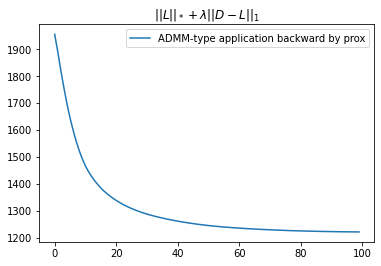

In [4]:
#@title # Now, enjoy the power of mathematics by low-rank and sparse modeling!


### Definitions

soft = lambda z, th: z.sign() * (z.abs() - th).max(torch.tensor(0., device=device))

## L1 loss
class L1LossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        ctx.save_for_backward(input, lw)
        return torch.sum(torch.abs(input)*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw = ctx.saved_tensors
        grad_input = grad_output.clone()
        return (input - soft(input, lw)) * grad_input, torch.abs(input) * grad_input

class L1Loss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(L1Loss, self).__init__()
        self.fn = L1LossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)

## Nuclear loss
class NuclearLossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        u, s, v = torch.svd(input)
        ctx.save_for_backward(input, lw, u, s, v)
        return torch.sum(s*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw, u, s, v = ctx.saved_tensors
        grad_input = grad_output.clone()
        svt_input = torch.matmul(torch.matmul(u, torch.diag_embed(soft(s,lw))), torch.transpose(v, -2, -1))
        return (input - svt_input) * grad_input, s * grad_input

class NuclearLoss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(NuclearLoss, self).__init__()
        self.fn = NuclearLossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


### Algorithm
from time import time

D = torch.from_numpy(DD.astype(np.float32)).to(device)

# Hyperparameters
ls = 1./np.sqrt(max(m,n)) / 32
ln = 1.
le = 1e+6

# Using L1Loss with prox
nucloss = NuclearLoss()
l1loss = L1Loss(lw=torch.tensor(ls))
l2loss = lambda x: torch.sum(x**2)

L, S, E, Y = 0, 0, 0, 0

t = time()
num_iter = 100
display_step = num_iter // 10
history_loss_inexact = []

for iter in range(num_iter):
    total_loss = 0.

    X = (D-S-E+Y).clone().detach().requires_grad_(True)
    loss = nucloss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    L = X.detach()

    X = (D-L-E+Y).clone().detach().requires_grad_(True)
    loss = l1loss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    S = X.detach()

    X = ((D-L-S+Y)/ (1+2*le)).clone().detach().requires_grad_(True)
    loss = l2loss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    E = X.detach()

    Y = Y + (D-L-S-E)

    total_loss = nucloss(L) + l1loss(D-L)

    history_loss_inexact.append(total_loss)
    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))

print((time()-t)*1000, ' [ms]')


### Results
import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
plt.legend()

print("Figure 2:  Original (DD),  frame differential (S),  background (L) !")

DLSanim = anim_make([  DD,  S.cpu().data.numpy(),  L.cpu().data.numpy()  ], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLSanim.to_html5_video())

$$\textrm{Minimize}_{(L,S)}\|L\|_* + \lambda_S \|S\|_1+\lambda_F\|D-(L+S)\|_F^2$$